In [1]:
from huggingface_hub import notebook_login
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.prompts import PromptTemplate
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

In [2]:
notebook_login()

In [33]:
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
vectorstore = Chroma(
    collection_name="database",
    embedding_function=embedding_model,
    persist_directory="database"
)
vectorstore._collection
num_chunks = len(vectorstore.get()["ids"])
print(f"Number of chunks loaded from 'database': {num_chunks}")
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

model_name = "meta-llama/Llama-3.2-1B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype=torch.float16
)
llama = pipeline("text-generation", model=model, tokenizer=tokenizer, max_new_tokens=300)

Number of chunks loaded from 'database': 1731


Device set to use cuda:0


In [38]:
COT_PROMPT = PromptTemplate.from_template("""
You are a helpful assistant with deep domain knowledge. Give full answer properly formatted.
Use the following context and a step-by-step reasoning approach to answer the user query:

Context:
{context}

User: {question}

Think through this problem step by step:
1. First, identify the key concepts in the question
2. Analyze how the retrieved context relates to these concepts
3. Construct a logical sequence of reasoning steps
4. Consider any important nuances or edge cases
5. Draw a clear conclusion based on these steps

Detailed step-by-step answer:                                     
""")

In [6]:
TOT_PROMPT = PromptTemplate.from_template("""
You are a chess strategist assistant. Present a Tree of Thought analysis for the following query.
Break down the concept into multiple distinct branches with sub-branches.

Context:
{context}

User: {question}

Create a proper tree structure with DETAILED and SPECIFIC content about the user's query.
Follow this format:
- Branch: [Main concept or approach]
  - SubBranch: [Specific aspect of the main concept]
    - Leaf: [Detailed insight about this specific aspect]
    - Leaf: [Another detailed insight]
  - SubBranch: [Another specific aspect]
    - Leaf: [Detailed insight]

EXAMPLE (about a different topic - do NOT use this content):
- Branch: Opening Theory
  - SubBranch: Principle of Development
    - Leaf: Knights before bishops promotes better coordination
    - Leaf: Central pawns should advance early to claim space
  - SubBranch: Pawn Structure
    - Leaf: Doubled pawns weaken the position but create open files
- Branch: Endgame Technique
  - SubBranch: Opposition
    - Leaf: Direct opposition allows kings to control critical squares
    - Leaf: Distant opposition works in a similar way with more space
  - SubBranch: Pawn Promotion
    - Leaf: Creating passed pawns is a primary winning strategy

YOUR RESPONSE MUST BE SPECIFICALLY ABOUT {question} with detailed, accurate information.
Use the exact prefix format shown: "Branch:", "SubBranch:", and "Leaf:".

Tree of Thought Analysis:
""")

In [7]:
GOT_PROMPT = PromptTemplate.from_template("""
You are a chess knowledge mapping assistant. Create a Graph of Thought analysis for the following chess question:

Question: {question}

INSTRUCTIONS:
You MUST format your response as a series of relationships using EXACTLY this format:
"ConceptA -- [relationship] --> ConceptB"

Each relationship must be on its own line with no bullet points or numbering.

Example of correctly formatted relationships:
"King's Gambit -- [sacrifices] --> f-pawn"
"Center Control -- [influences] --> Attack Opportunities"
"Piece Development -- [enhances] --> Center Control"

DO NOT LIST CONCEPTS WITHOUT RELATIONSHIPS.
DO NOT USE BULLET POINTS OR NUMBERING.
DO NOT INCLUDE ANY EXPLANATORY TEXT BEFORE OR AFTER THE RELATIONSHIPS.

Provide at least 8-10 relationships that explain how the concepts in chess are connected regarding this question.

Graph of Thought Analysis:
""")

In [28]:
def query_docs(query: str):
    docs = retriever.get_relevant_documents(query)
    print(f"\n Query: {query}")
    print(f"Retrieved {len(docs)} relevant document chunks")
    return "\n\n".join([doc.page_content for doc in docs])


In [9]:
import matplotlib.pyplot as plt
import networkx as nx

def visualize_cot_chain(answer):
    # Extract steps (lines starting with numbers or marked clearly as steps)
    steps = []
    for line in answer.split('\n'):
        line = line.strip()
        if line and (line[0].isdigit() or line.startswith("Step")):
            steps.append(line)
    
    if not steps:
        # Fallback: split by sentences if no clear steps
        import re
        steps = [s.strip() for s in re.split(r'\.(?=\s|$)', answer) if s.strip()]
    
    # Create a directed graph with sequential steps
    G = nx.DiGraph()
    for i in range(len(steps) - 1):
        G.add_edge(steps[i], steps[i + 1])
    
    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42, k=0.9)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=3000, font_size=9, arrows=True, 
            arrowsize=15, edge_color='blue')
    plt.title("Chain of Thought Reasoning")
    plt.tight_layout()
    plt.savefig("cot_visualization.png", dpi=300)
    plt.show()


In [10]:
def visualize_tot_tree(answer):
    """
    Visualize a Tree of Thought using matplotlib and networkx.
    Designed to handle the specific prefix format: Branch:, SubBranch:, Leaf:
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add the root node
    root = "Root"
    G.add_node(root)
    
    # Track current branch and sub-branch
    current_branch = None
    current_subbranch = None
    
    # Parse the response line by line
    for line in answer.split('\n'):
        line = line.strip()
        if not line:
            continue
        
        # Check for branch prefix
        if line.startswith("- Branch:") or line.startswith("Branch:"):
            branch_name = line.replace("- Branch:", "").replace("Branch:", "").strip()
            current_branch = branch_name
            current_subbranch = None
            G.add_node(branch_name)
            G.add_edge(root, branch_name)
            
        # Check for sub-branch prefix
        elif line.startswith("  - SubBranch:") or line.startswith("SubBranch:"):
            subbranch_name = line.replace("  - SubBranch:", "").replace("SubBranch:", "").strip()
            current_subbranch = subbranch_name
            if current_branch:
                G.add_node(subbranch_name)
                G.add_edge(current_branch, subbranch_name)
                
        # Check for leaf prefix
        elif line.startswith("    - Leaf:") or line.startswith("Leaf:"):
            leaf_name = line.replace("    - Leaf:", "").replace("Leaf:", "").strip()
            if current_subbranch:
                G.add_node(leaf_name)
                G.add_edge(current_subbranch, leaf_name)
    
    # If no branches were added, the answer doesn't have the expected format
    if len(G.nodes()) <= 1:
        # Try a more flexible parsing approach
        current_level = 0
        current_nodes = {0: root}
        
        for line in answer.split('\n'):
            line = line.strip()
            if not line or line.startswith("Tree of Thought"):
                continue
                
            # Determine indentation level
            indent = len(line) - len(line.lstrip())
            level = indent // 2 + 1  # +1 because root is level 0
            
            # Clean the line
            clean_line = line.lstrip('- ').strip()
            
            # Skip instruction lines
            if any(x in clean_line for x in ["Main branches", "Sub-branches", "Leaf nodes"]):
                continue
                
            # Add the node to the graph
            if clean_line and clean_line not in G.nodes():
                G.add_node(clean_line)
                
                # Connect to parent
                parent_level = max([l for l in current_nodes.keys() if l < level], default=0)
                G.add_edge(current_nodes[parent_level], clean_line)
                
                # Update current nodes
                current_nodes[level] = clean_line
    
    # Use a layout appropriate for trees
    try:
        # Try to use a hierarchical layout
        pos = nx.nx_pydot.graphviz_layout(G, prog="dot")
    except:
        # Fall back to a spring layout if pydot is not available
        pos = nx.spring_layout(G, seed=42)
    
    # Create a larger figure for better readability
    plt.figure(figsize=(15, 12))
    
    # Draw nodes with different colors based on their level
    node_colors = []
    node_sizes = []
    
    for node in G.nodes():
        # Determine node level based on distance from root
        try:
            level = nx.shortest_path_length(G, root, node)
        except:
            level = 0
            
        if level == 0:  # Root
            node_colors.append('lightblue')
            node_sizes.append(3000)
        elif level == 1:  # Main branches
            node_colors.append('lightgreen')
            node_sizes.append(2500)
        elif level == 2:  # Sub-branches
            node_colors.append('lightyellow')
            node_sizes.append(2000)
        else:  # Leaf nodes
            node_colors.append('lightcoral')
            node_sizes.append(1500)
    
    # Draw the graph with the calculated properties
    nx.draw(G, pos, 
            with_labels=True, 
            node_color=node_colors,
            node_size=node_sizes,
            font_size=9, 
            arrows=True,
            arrowsize=15, 
            edge_color='green',
            width=1.5,
            font_weight='bold')
    
    plt.title("Tree of Thought Analysis", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("tot_visualization.png", dpi=300)
    plt.show()

In [11]:
def visualize_got_graph(answer):
    G = nx.DiGraph()
    
    # Extract relationships with labeled edges
    import re
    relationships = []
    
    # Pattern to match "ConceptA -- [relationship] --> ConceptB"
    pattern = r'([^-]+)\s*--\s*\[(.*?)\]\s*-->\s*([^-]+)'
    
    # Remove any markdown formatting, bullet points, or numbering
    lines = []
    for line in answer.strip().split('\n'):
        line = line.strip()
        # Skip empty lines and lines that start with bullet points or numbers
        if line and not line.startswith(('•', '-', '*', '1.', '2.', '3.', '4.', '5.', '6.', '7.', '8.', '9.', '0.')):
            # Remove leading markers if they exist
            if ' - ' in line[:5]:  # Check only beginning of line
                line = line.split(' - ', 1)[1]
            lines.append(line)
    
    # Check if we have any lines to process
    if not lines:
        print("No valid lines found in the response.")
        return None
    
    # Try to extract relationships using the pattern
    for line in lines:
        match = re.search(pattern, line)
        if match:
            source = match.group(1).strip()
            relationship = match.group(2).strip()
            target = match.group(3).strip()
            relationships.append((source, target, relationship))
    
    # If no relationships found, try to infer them
    if not relationships:
        print("No formatted relationships found. Trying to create basic connections...")
        
        # Create basic connections between consecutive concepts
        concepts = [line.strip() for line in lines if line.strip()]
        for i in range(len(concepts) - 1):
            relationships.append((concepts[i], concepts[i+1], "relates to"))
    
    # If still no relationships, give up
    if not relationships:
        print("Failed to extract any relationships.")
        print("Raw answer text:", answer)
        return None
    
    # Create the graph
    for source, target, relationship in relationships:
        G.add_edge(source, target, label=relationship)
    
    # Visualization code (same as before)
    plt.figure(figsize=(14, 10))
    pos = nx.spring_layout(G, seed=42, k=0.9)
    
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=3000, alpha=0.8)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')
    nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=15, width=1.5)
    
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    
    plt.title("Graph of Thought Analysis", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig("got_visualization.png", dpi=300, bbox_inches='tight')
    
    print(f"Graph created with {len(G.nodes)} nodes and {len(G.edges)} edges")
    
    plt.show()
    return G

In [12]:
def process_query(query, reasoning_type="cot"):
    """
    Process a query using the specified reasoning approach.
    
    Args:
        query: The user's question
        reasoning_type: One of 'cot', 'tot', or 'got'
        
    Returns:
        Processed answer and visualization
    """
    # Retrieve relevant context
    context = query_docs(query)
    
    # Select the appropriate reasoning approach
    if reasoning_type.lower() == "cot":
        prompt = COT_PROMPT.format(context=context, question=query)
        answer = llama(prompt)[0]["generated_text"].replace(prompt, "").strip()
        visualize_cot_chain(answer)
        
    elif reasoning_type.lower() == "tot":
        prompt = TOT_PROMPT.format(context=context, question=query)
        answer = llama(prompt)[0]["generated_text"].replace(prompt, "").strip()
        visualize_tot_tree(answer)
        
    elif reasoning_type.lower() == "got":
        prompt = GOT_PROMPT.format(context=context, question=query)
        answer = llama(prompt)[0]["generated_text"].replace(prompt, "").strip()
        visualize_got_graph(answer)
    
    return answer

In [31]:
query = "How does the King's Gambit affect center control in chess?"

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.



 Query: How does the King's Gambit affect center control in chess?
Retrieved 3 relevant document chunks


C:\Users\krish\AppData\Local\Temp\ipykernel_34144\1250702219.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


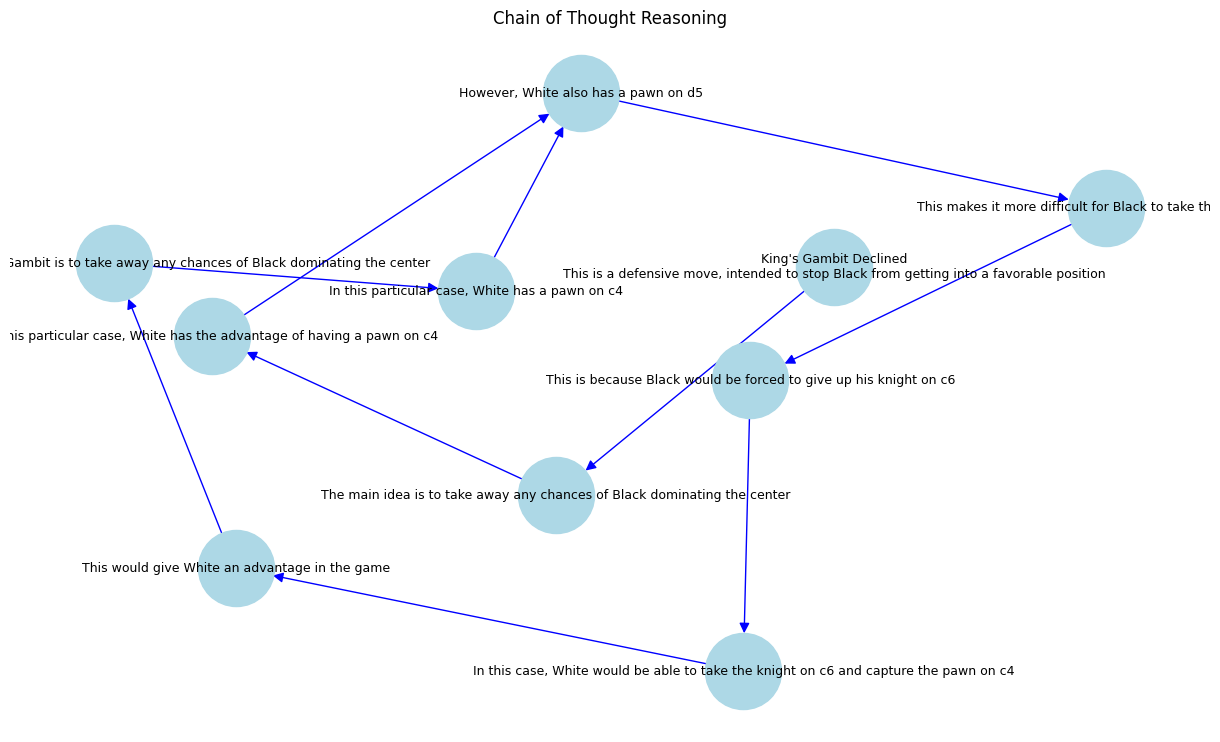

Chain of Thought Result:
 King's Gambit Declined
This is a defensive move, intended to stop Black from getting into a favorable position. The main idea is to take away any chances of Black dominating the center. In this particular case, White has the advantage of having a pawn on c4. However, White also has a pawn on d5. This makes it more difficult for Black to take the pawn on c4. This is because Black would be forced to give up his knight on c6. In this case, White would be able to take the knight on c6 and capture the pawn on c4. This would give White an advantage in the game. The main idea behind the King's Gambit is to take away any chances of Black dominating the center. In this particular case, White has a pawn on c4. However, White also has a pawn on d5. This makes it more difficult for Black to take the pawn on c4. This is because Black would be forced to give up his knight on c6. In this case, White would be able to take the knight on c6 and capture the pawn on c4. This woul

In [39]:
cot_result = process_query(query, "cot")
print("Chain of Thought Result:\n", cot_result)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


C:\Users\krish\AppData\Local\Temp\ipykernel_34144\2076667963.py:131: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


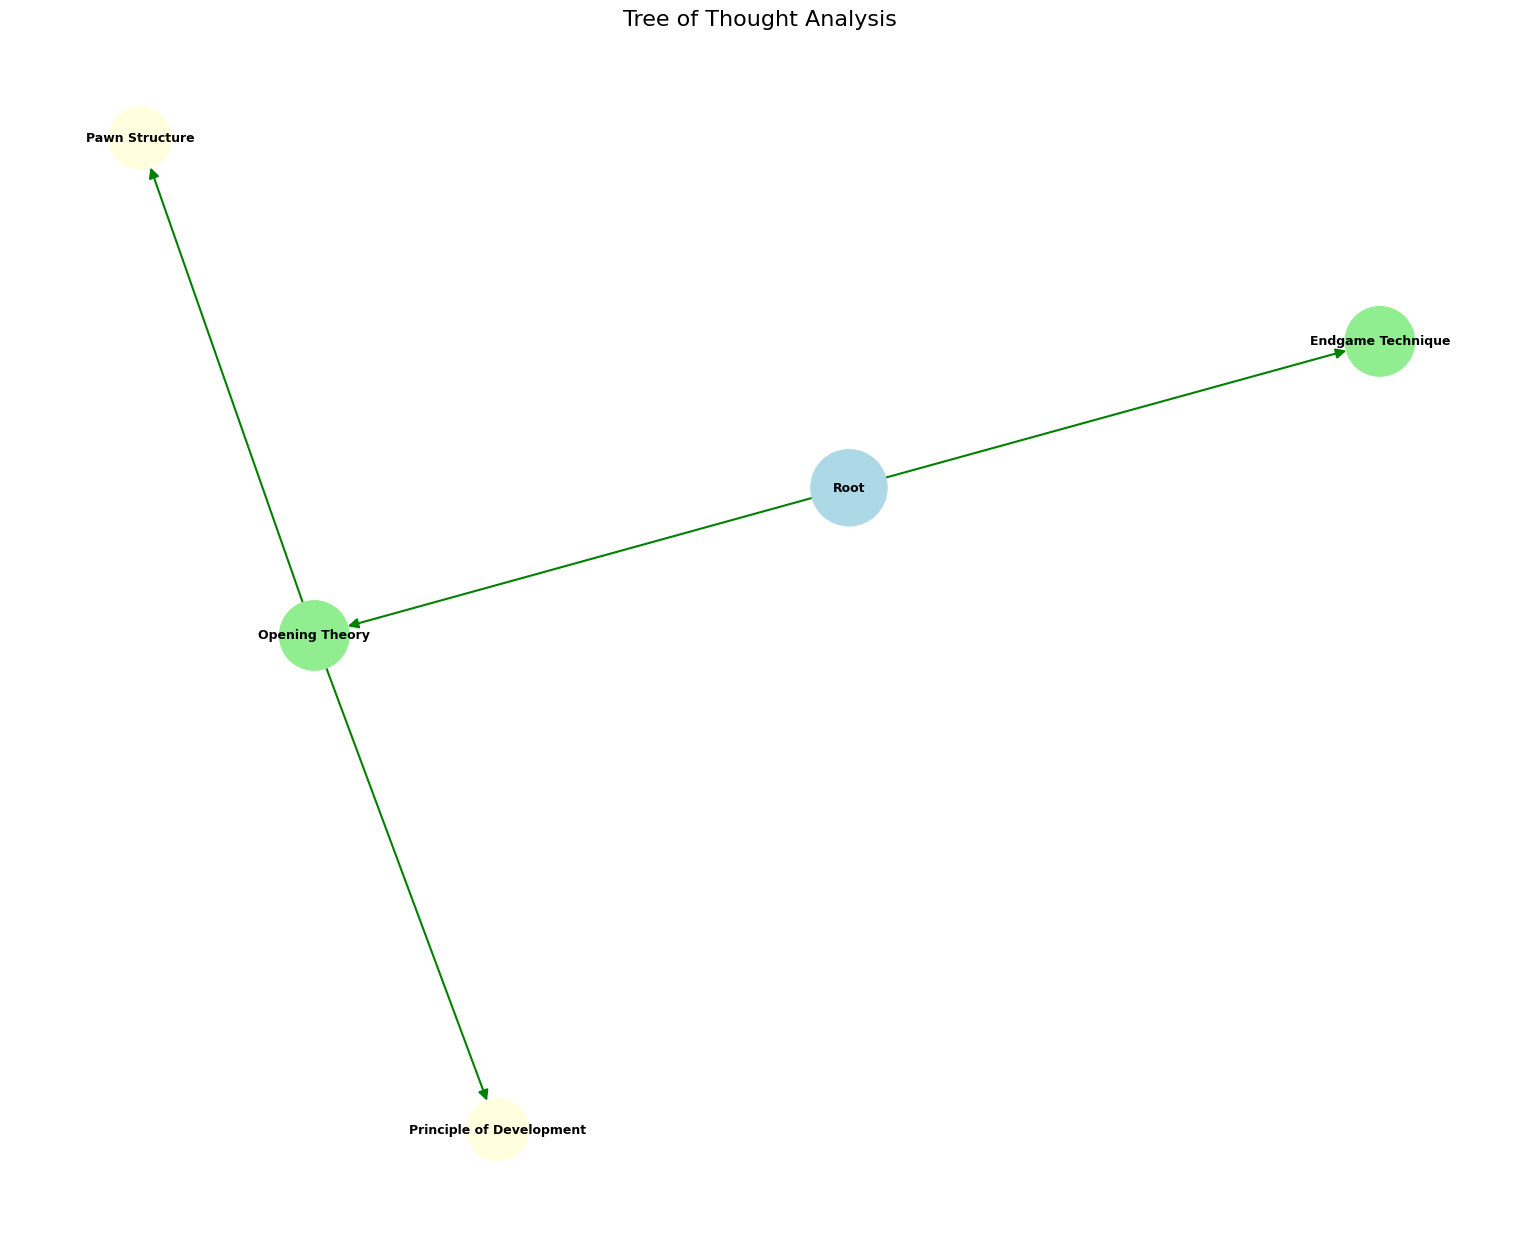

Tree of Thought Result:
 Branch: Opening Theory
SubBranch: Principle of Development
  - Leaf: Knights before bishops promotes better coordination
  - Leaf: Central pawns should advance early to claim space
SubBranch: Pawn Structure
  - Leaf: Doubled pawns weaken the position but create open files
  - Leaf: Pawn promotion is a primary winning strategy

Branch: Endgame Technique
  - SubBranch: Opposition
    - Leaf: Direct opposition allows kings to control critical squares
    - Leaf: Distant opposition works in a similar way with more space
  - SubBranch: Pawn Promotion
    - Leaf: Creating passed pawns is a primary winning strategy


In [15]:
tot_result = process_query(query, "tot")
print("Tree of Thought Result:\n", tot_result)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


No formatted relationships found. Trying to create basic connections...
Graph created with 6 nodes and 6 edges


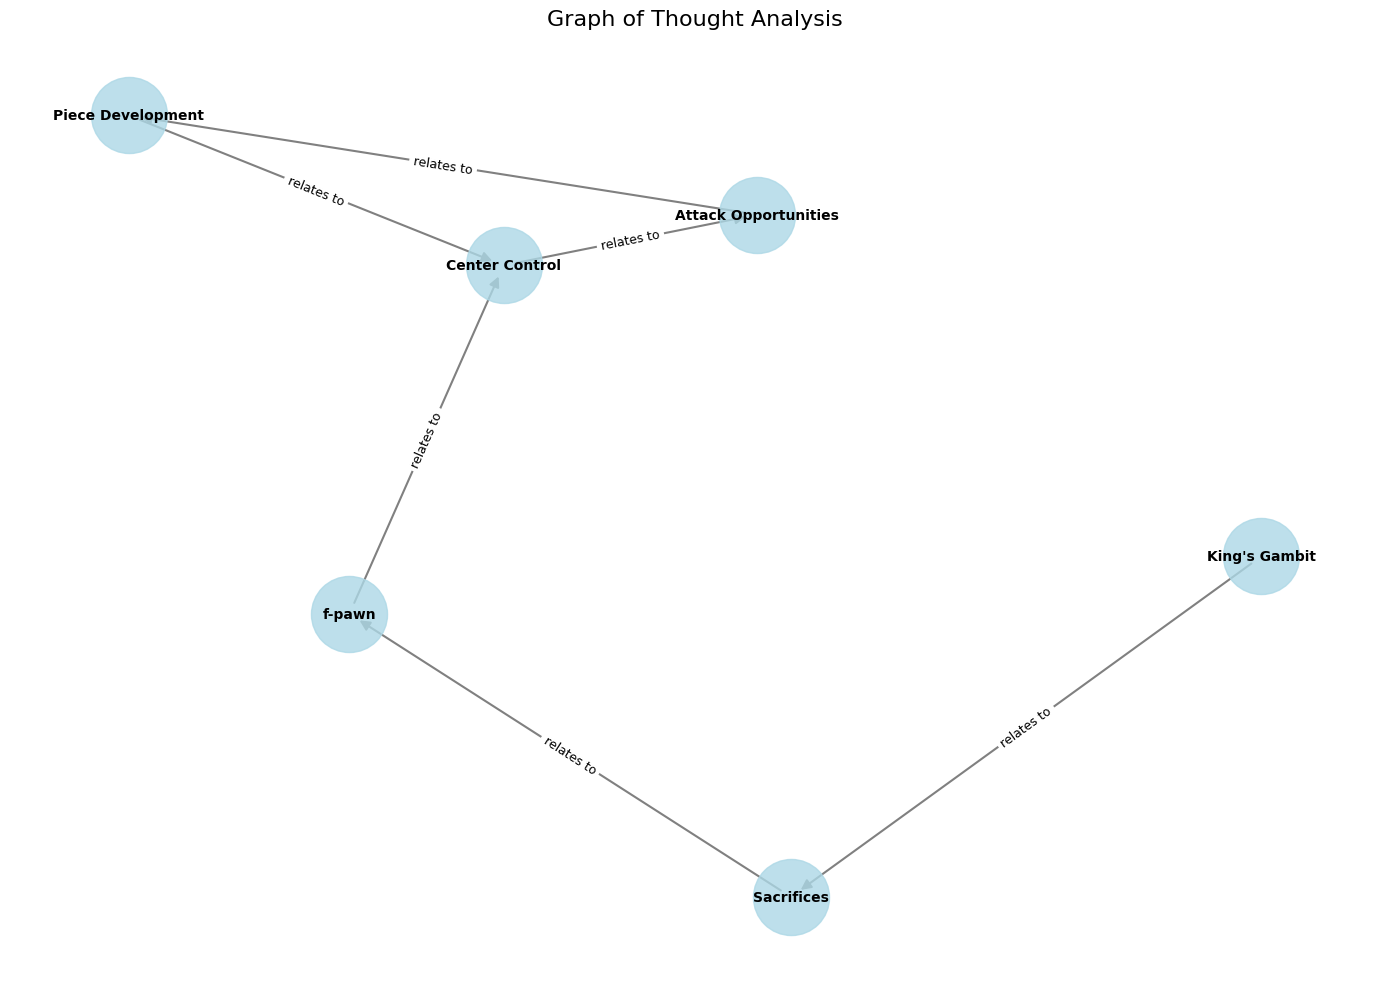

Graph of Thought Result:
 King's Gambit
    Sacrifices
    f-pawn
    Center Control
    Attack Opportunities
    Piece Development
    Center Control


In [17]:
got_result = process_query(query, "got")
print("Graph of Thought Result:\n", got_result)